# Описание проекта.

  Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя.  
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

In [34]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Загрузим данные из предоставленных директорий:

In [35]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Просмотрим общую информацию о таблице 'labels':

In [36]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [37]:
labels.shape

(7591, 2)

In [38]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В таблице 'labels' содержится информация о реальном возрасте.
Построим график распределения возраста в выборке:

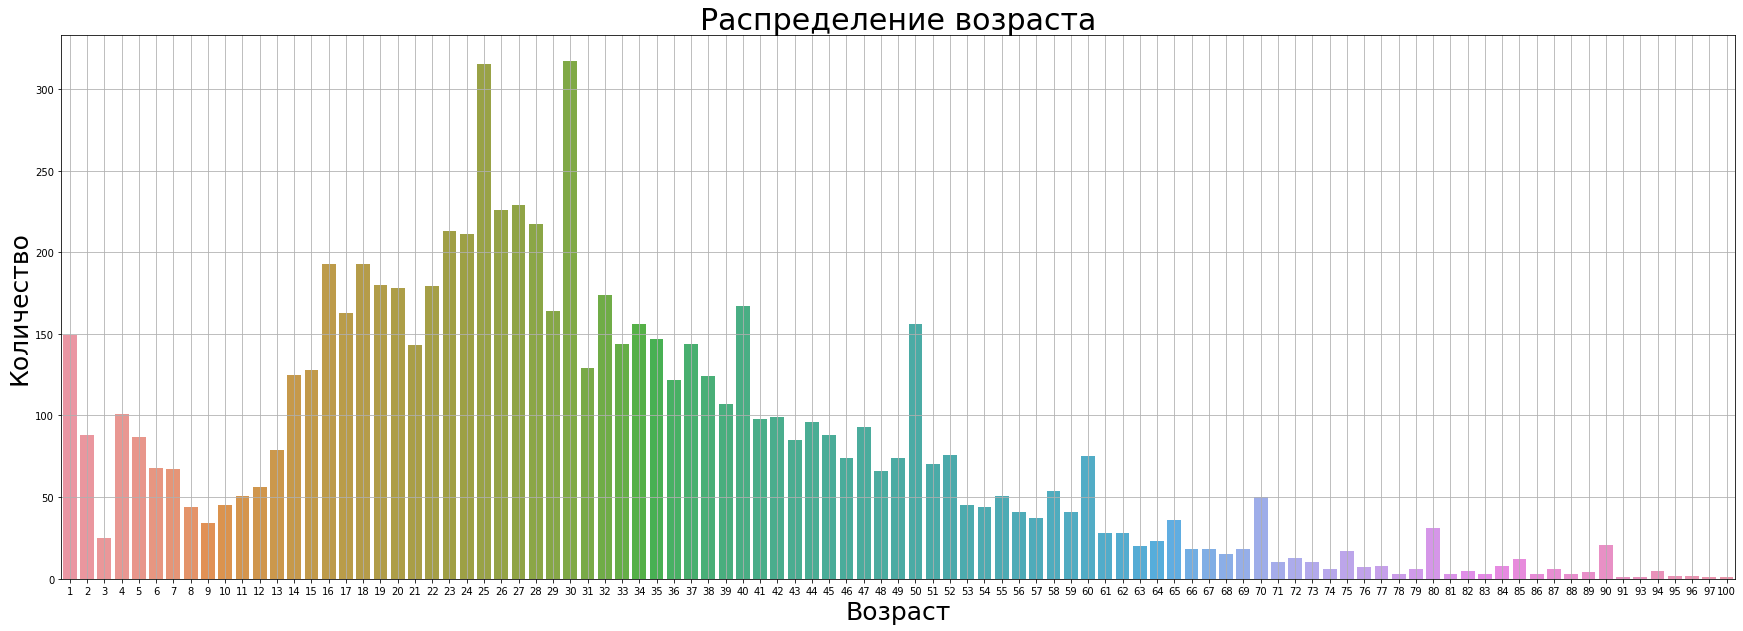

In [39]:
plt.figure(figsize=(30,10))
sns.countplot(x='real_age', data=labels)
plt.title('Распределение возраста', size=30)
plt.ylabel('Количество', size=25)
plt.xlabel('Возраст', size=25)
plt.grid(True)

In [40]:
len(labels[(labels['real_age'] > 15) & (labels['real_age'] <41)]) / len(labels)

0.5974179949940719

В выборке присутствуют фото людей в возрасте от 1 до 100 лет. Основное количество фото людей в возрасте от 14 до 40 лет - примерно 60%. Заметно выделяются по количеству 2 возраста - 25 и 30 лет. Также по количеству выделяется группа от 1 до 7 лет.

Напечатаем на экране 15 фотографий:

In [41]:
features, target = next(train_gen_flow)

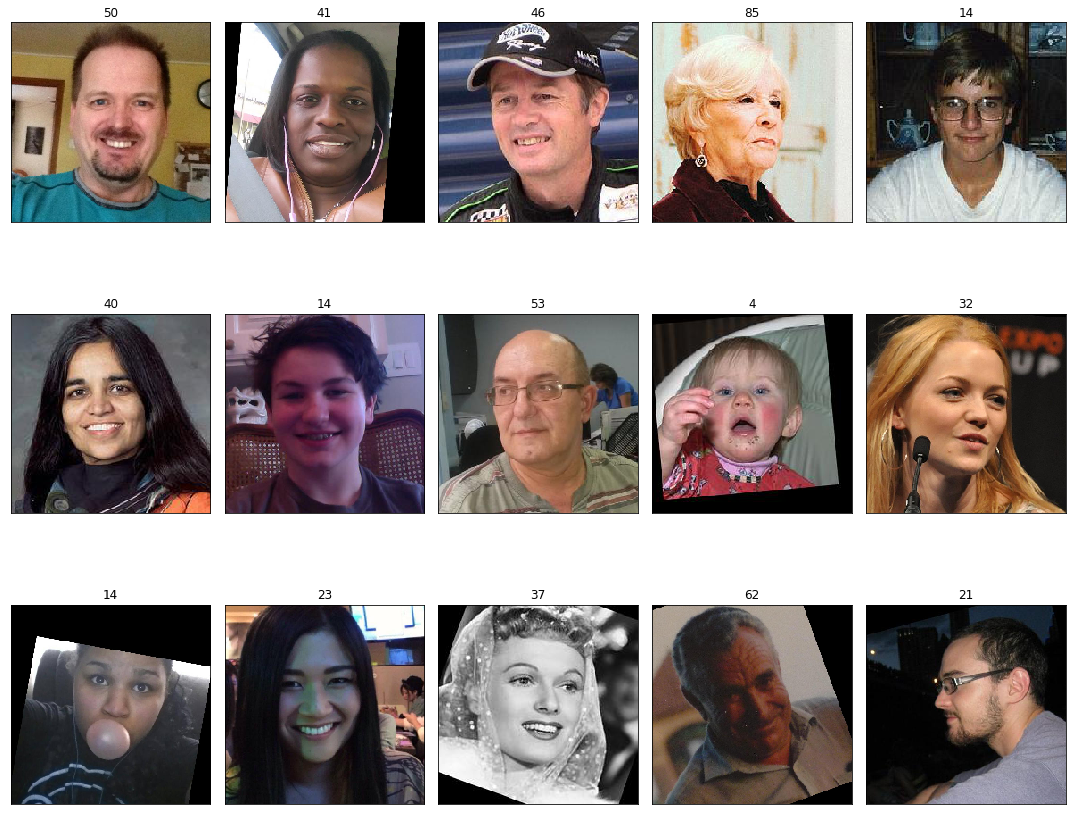

In [42]:
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

Загружены данные из 2 файлов, один из которых содержит 7591 фото лиц людей разного возраста, второй файл содержит информацию о номере фото и реальный возраст человека на этом фото. Фото при загрузке приведены к размеру 224Х224 пикселей. Далее построен график распределения по возрасту. Также выведены 15 фотографий для просмотра.

# 2. Обучение модели

Код в этом разделе запускался на сервере с графической картой (GPU) [Yandex Compute Cloud](https://cloud.yandex.ru/services/compute), поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)

    return model
```


Train for 190 steps, validate for 48 steps
Epoch 1/5
2020-07-25 19:27:18.987608: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-25 19:27:22.940419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 105s - loss: 249.1379 - mae: 11.5084 - val_loss: 563.0953 - val_mae: 18.5787
Epoch 2/5
190/190 - 42s - loss: 101.6985 - mae: 7.6268 - val_loss: 542.8742 - val_mae: 17.9891
Epoch 3/5
190/190 - 42s - loss: 77.2624 - mae: 6.7018 - val_loss: 221.6486 - val_mae: 11.3813
Epoch 4/5
190/190 - 42s - loss: 63.3179 - mae: 6.0534 - val_loss: 115.8407 - val_mae: 8.1242
Epoch 5/5
190/190 - 42s - loss: 53.8397 - mae: 5.5131 - val_loss: 87.0361 - val_mae: 6.9932
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 87.0361 - mae: 6.9932
Test MAE: 6.9932

# 3. Анализ обученной модели

До обучения модели признаки были масштабированы до значений от 0 до 1. Для увеличения выборки было произведено отзеркаливание фото. Для обучения модели была использована архитектура ResNet50 с оключенными 2 последними слоями. Эти 2 слоя создали вручную:GlobalAveragePooling2D для усреднения информации по всему изображению; и полносвязный слой Dense для регрессии с одним нейроном. Для оценки качества модели применили метрику МАЕ. После обучения модели результат предсказаний на тестовой выборке МАЕ = 6.99 при необходимой по требованиям проекта минимальной МАЕ=8.